In [1]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
data_folder_path = '../../../data'
sys.path.append(data_folder_path)
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
sys.path.append('../../../mogp_decomposition/')
import mwgp as mwgp
from mwgp import GPD
import glob
import seaborn as sns
from evaluation import *
from GRM import *

def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-23 20:40:00.947865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 20:40:01.106458: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 20:40:01.145112: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 20:40:01.950069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Using GPU #0
Using GPU #0


## Loading Dataset PBMC

In [5]:
file_path = os.path.join(data_folder_path, 'PBMC10k', 'pbmc10k.h5mu')
mdata = mu.read(file_path)
mu.pp.intersect_obs(mdata)
rna = mdata.mod['rna']
atac = mdata.mod['atac']

col_dict1 = {'CD4+ naïve T': '#8000ff',
                 'CD8+ activated T': '#5641fd',
                 'naïve B': '#2c7ef7',
                 'intermediate mono': '#00b5eb',
                 'MAIT': '#2adddd',
                 'mDC': '#54f6cb',
                 'CD14 mono': '#80ffb4',
                 'memory B': '#abf69b',
                 'CD8+ naïve T': '#d4dd80',
                 'pDC': '#ffb360',
                 'CD16 mono': '#ff7e41',
                 'CD4+ memory T': '#ff4121',
                 'NK': '#ff0000',
                 None: '#CDC9C9'}
#This list defines the assigned cell type based on the top marker genes in rank_genes_groups
cell_type_list_modified1=['CD4+ memory T', 'CD4+ naïve T','intermediate mono','CD8+ naïve T','CD14 mono',
               'CD8+ activated T', 'memory B', 'NK', 'CD16 mono', 'ignore',  'naïve B', 'mDC','ignore',  'MAIT'
                         , 'pDC','ignore','ignore' ]    
rank_genes_groups=rna.uns["rank_genes_groups"]["names"]

#This list defines the assigned cell type based on the top marker peaks in rank_peaks_groups
cell_type_list_modified2=['intermediate mono', 'CD4+ memory T','CD8+ naïve T','CD4+ naïve T','CD14 mono',
               'CD8+ activated T', 'memory B', 'NK', 'ignore', 'mDC',  'MAIT', 'pDC','ignore','ignore']
rank_peaks_groups=atac.uns["rank_genes_groups"]["names"]        

In [6]:
rna

AnnData object with n_obs × n_vars = 9393 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
atac

AnnData object with n_obs × n_vars = 9393 × 5000
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'atac', 'celltype_colors', 'files', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'lsi', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap'
    varm: 'LSI', 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
RNA_Normalized_2000 = (rna.X-np.mean(rna.X,0))/np.std(rna.X,0)

ATAC_Normalized_2000 = (atac.X-np.mean(atac.X,0))/np.std(atac.X,0)

In [9]:
np.random.seed(11111986)
[I,J] = RNA_Normalized_2000.shape
[I,K] = ATAC_Normalized_2000.shape

In [10]:
[i,j] = np.nonzero(RNA_Normalized_2000)
X_tr1 = []
for cnt in range(len(i)):
    X_tr1.append([i[cnt],j[cnt]])
X_tr1 = np.asarray(X_tr1)
Y_tr1 = RNA_Normalized_2000.ravel()
 

In [11]:
[i,j] = np.nonzero(ATAC_Normalized_2000)
X_tr2 = []
for cnt in range(len(i)):
    X_tr2.append([i[cnt],j[cnt]])
X_tr2 = np.asarray(X_tr2)
Y_tr2 = ATAC_Normalized_2000.ravel()
 

In [12]:
print(X_tr1.shape)
print(X_tr2.shape)
print(Y_tr1.shape)
print(Y_tr2.shape)

(18786000, 2)
(46965000, 2)
(18786000,)
(46965000,)


## Evaluation

In [11]:
# Top 100 marker genes for each cell type will be defined using C1
C1 = np.array([None] * J)
n_marker_genes = 100
for i in range(len(cell_type_list_modified1)):
    if cell_type_list_modified1[i] not in {'ignore'}:
        for j in range(n_marker_genes):
            C1[np.where(rna.var_names.values==rank_genes_groups[j][i])]=(cell_type_list_modified1[i])

### Multi-view analysis (Global Representation)
#### By adjusting the values of the latent dimensions for cell and gene, and peak embeddings, as well as the number of epochs and batch sizes, we generate embeddings using MOGP followed by UMAP embedding. The accuracy and Rand index of these global representations are provided, and the plots are visualized.
#### Each figure displays cell embeddings, gene embeddings, and peak embeddings. The colors represent the cell type of each cell or the cell type corresponding to each marker gene or marker peak.

In [28]:
for filename in glob.glob('./Results/global.csv'):
    os.remove(filename)
os.makedirs("./Results", exist_ok=True)
filehandler = open("./Results/global.csv","wb")
dim_arr=[2, 4, 8, 16, 32]
num_epochs_arr=[100, 500]
n_inducing_points_arr=[512]
batch_size_arr=[100000, 60000, 20000, 10000, 10000]
with_PCA_arr=[0]
with_PPCA_arr=[0]
scale_emb1_arr=[0]
scale_emb2_arr=[0]
emb_reg_arr=[0.001]
lr = float(0.01)
kernel = ["RBF"]

for l in range(5):
     for m in range(2):
        for n in range(1): 
            for p in range(1): 
                for q in range(1): 
                    for r in range(1):
                        for s in range(1):
                            for t in range(1):
                                dim1 = dim_arr[l]
                                dim2 = dim_arr[l]
                                dim3 = dim_arr[l]
                                num_epochs = num_epochs_arr[m]
                                n_inducing_points1 = n_inducing_points_arr[n]
                                n_inducing_points2 = n_inducing_points_arr[n]
                                batch_size = batch_size_arr[l]
                                with_PCA=with_PCA_arr[p]
                                with_PPCA=with_PPCA_arr[q]
                                scale_emb1=scale_emb1_arr[r]
                                scale_emb2=scale_emb2_arr[s]
                                emb_reg=emb_reg_arr[t]
                                if (with_PCA==0 or with_PPCA==0):
                                    title = ' dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
                                    save_path = './PBMC10K-MultiView-GPFlux'+title+'/' 
                                    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
                                    hyper_params = {
                                    'I':I,
                                    'J':J,
                                    'K':K,    # the number of entities in each domain
                                    'M1': n_inducing_points1,                  # the number of inducing pairs
                                    'M2': n_inducing_points2,                  # the number of inducing pairs
                                    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
                                    'batch_size':batch_size,      # the size of training batches
                                    'obs_mean1': Y_tr1.mean(),  # the mean of target
                                    'obs_mean2': Y_tr2.mean(),  # the mean of target
                                    'emb_reg': emb_reg,          # l2 norm on the embeddings
                                    'lr': lr,                # the learning rate 
                                    'save_path': save_path,        # path to save the trained models.
                                    }  
                                    
                                    gp_md = GPD(**hyper_params)
                                    gp_md.build(kernels=kernel)
                                    gp_md.load_model((X_tr1+1), (X_tr2+1))
                                    
                                    emb1 = gp_md.emb1
                                    embs1 = emb1((X_tr1+1)[0:-1:J,0])
                                    
                                    emb2 = gp_md.emb2
                                    embs2 = emb2((X_tr1+1)[0:J,1])
                                    
                                    RNA_struct_MOGP = ad.AnnData(embs1.numpy())
                                    RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()
                                    #sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, n_pcs=8)
                                    sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, use_rep='X')
                                    sc.tl.umap(RNA_struct_MOGP, alpha=0.3, min_dist=.5)
                                    
                                    Acc_cells_arr=[]
                                    ARI_cells_arr=[]
                                    for cnt in range (10):
                                        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
                                        clusterer.fit(RNA_struct_MOGP.obsm['X_umap'])
                                        cluster_labels = clusterer.predict(RNA_struct_MOGP.obsm['X_umap'])
                                        labels=np.array([col_dict1[i] for i in rna.obs["celltype"]])
                                        Acc_cells_arr.append(purity_score(labels, cluster_labels)[0]) 
                                        ARI_cells_arr.append(purity_score(labels, cluster_labels)[1]) 
                                
                                    Genes_struct_MOGP = ad.AnnData(embs2.numpy())
                                    Genes_struct_MOGP.obsm['X_tsne']= embs2.numpy()
                                    sc.pp.neighbors(Genes_struct_MOGP, n_neighbors=30, n_pcs=8)
                                    sc.tl.umap(Genes_struct_MOGP, alpha=0.3, min_dist=.5)
                                    #sc.pl.umap(Genes_struct_MOGP, use_raw=False, ncols=5, size=70,)
                                    Acc_genes_arr=[]
                                    ARI_genes_arr=[]
                                    for cnt in range (10):
                                        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
                                        clusterer.fit(Genes_struct_MOGP.obsm['X_umap'])
                                        cluster_labels_genes = clusterer.predict(Genes_struct_MOGP.obsm['X_umap'])
                                        train_labels_genes = np.array([col_dict1[i] for i in C1])
                                        Acc_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[0]) 
                                        ARI_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[1]) 
                                    
                                    
                                    pickle.dump(title,filehandler)
                                    pickle.dump(np.mean(Acc_cells_arr),filehandler)
                                    pickle.dump(np.mean(ARI_cells_arr),filehandler)
                                    pickle.dump(np.mean(Acc_genes_arr),filehandler)
                                    pickle.dump(np.mean(ARI_genes_arr),filehandler)
                                    
                                    
filehandler.close()            

2024-01-31 19:17:00.163524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 19:17:00.796875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14774 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fde246ffee0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd9c81314c0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdf43a6a550>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdf43a6a550>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdf43a2aee0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdf19f4f8b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdf19f4f8b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdf100ae040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdf100ae040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fdf100ae040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd5580ecca0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd283dd3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd283dd3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd4d16adc10>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd4d105ea60>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd4d105ea60>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd4d0980f70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd4d0add430>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd4d0add430>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd49d3cf670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd49d3cf670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd27af43700>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd49c14bd30>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd41dcba280>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd49d1871f0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd2722c4670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd2716a8550>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd41cd5f040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_986240/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd41c559c10>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd41dbc2e50>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd41dbc2e50>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

2024-06-09 17:08:26.144452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 17:08:27.117477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14778 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:86:00.0, compute capability: 7.5
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/la

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
 dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.3518897050995422     ARI_cells:0.45759103866684026
Acc_genes:0.8214     ARI_cells:0.16224978124785322


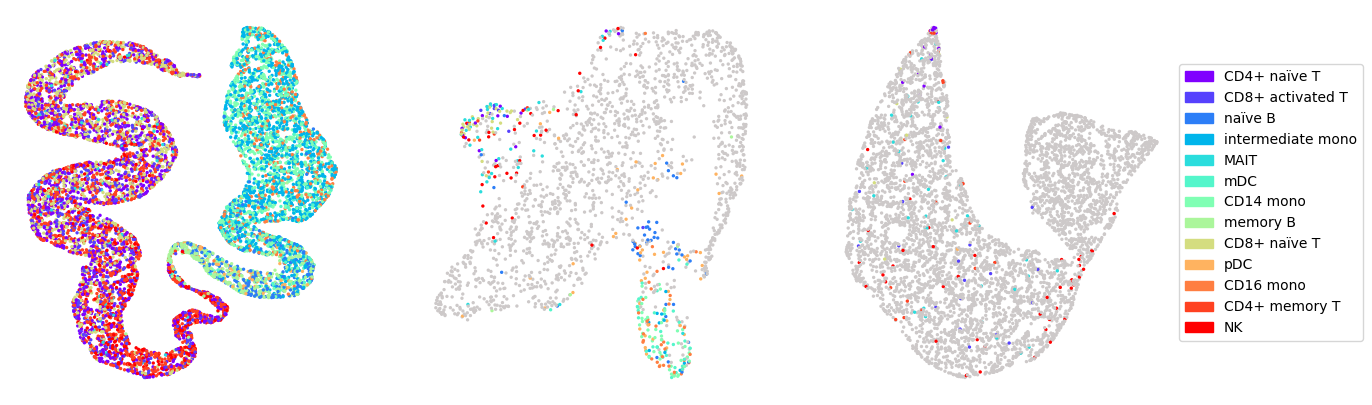

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


 dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.731150857021186     ARI_cells:0.7080359961238702
Acc_genes:0.81935     ARI_cells:0.2156009670782184


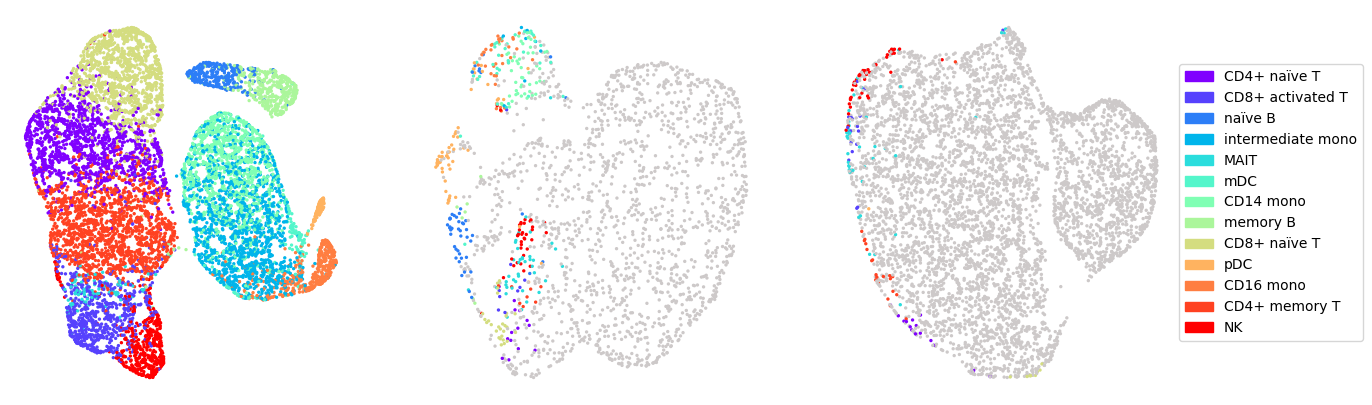

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=8` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


 dim1=4  dim2=4  dim3=4  InducingPoints1=512  InducingPoints2=512  BatchSize=60000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.7732460342808474     ARI_cells:0.7297021541338735
Acc_genes:0.8190500000000001     ARI_cells:0.06880824188643742


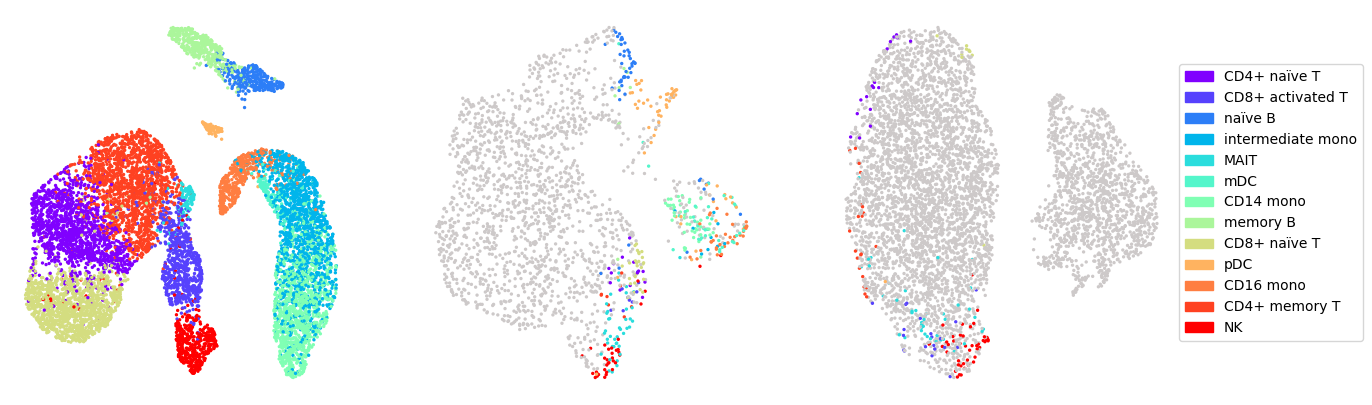

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=8` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


 dim1=4  dim2=4  dim3=4  InducingPoints1=512  InducingPoints2=512  BatchSize=60000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.7854679016288726     ARI_cells:0.7369192576794982
Acc_genes:0.8189500000000001     ARI_cells:0.08948974465639253


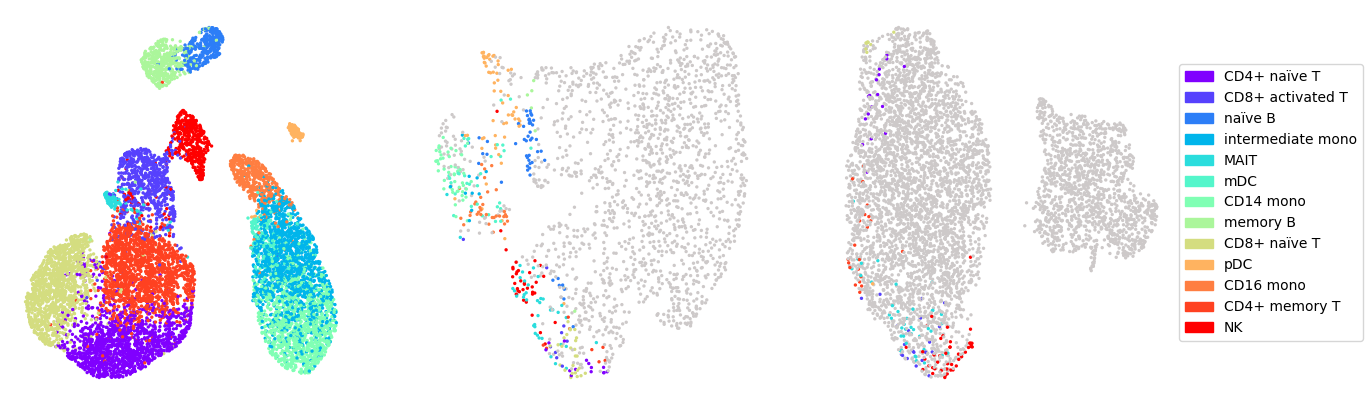

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=16` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


 dim1=8  dim2=8  dim3=8  InducingPoints1=512  InducingPoints2=512  BatchSize=20000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.7796870009581603     ARI_cells:0.7321088848006889
Acc_genes:0.8182499999999999     ARI_cells:0.060443847069399335


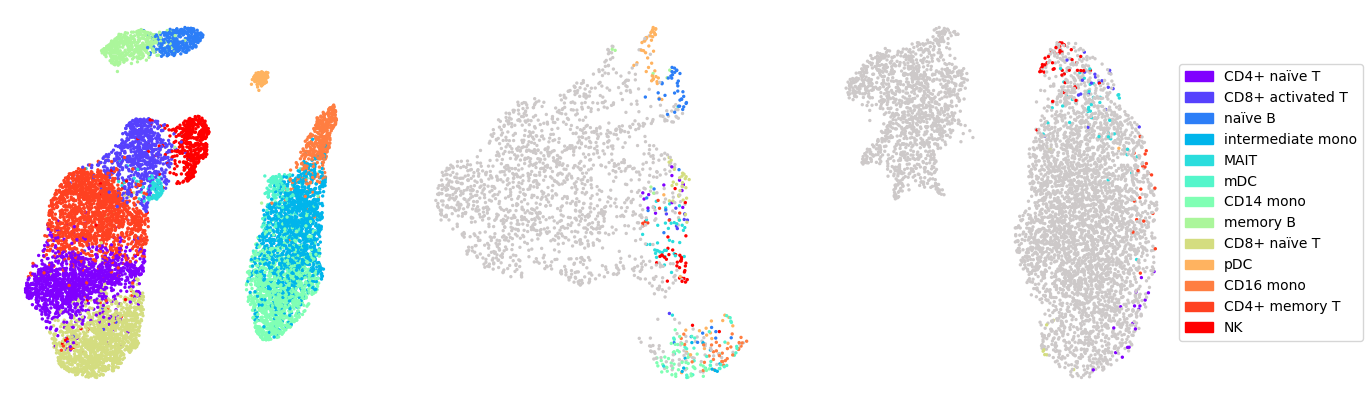

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=16` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


 dim1=8  dim2=8  dim3=8  InducingPoints1=512  InducingPoints2=512  BatchSize=20000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.7671457468327478     ARI_cells:0.7103846882823992
Acc_genes:0.8209     ARI_cells:0.09104838504477389


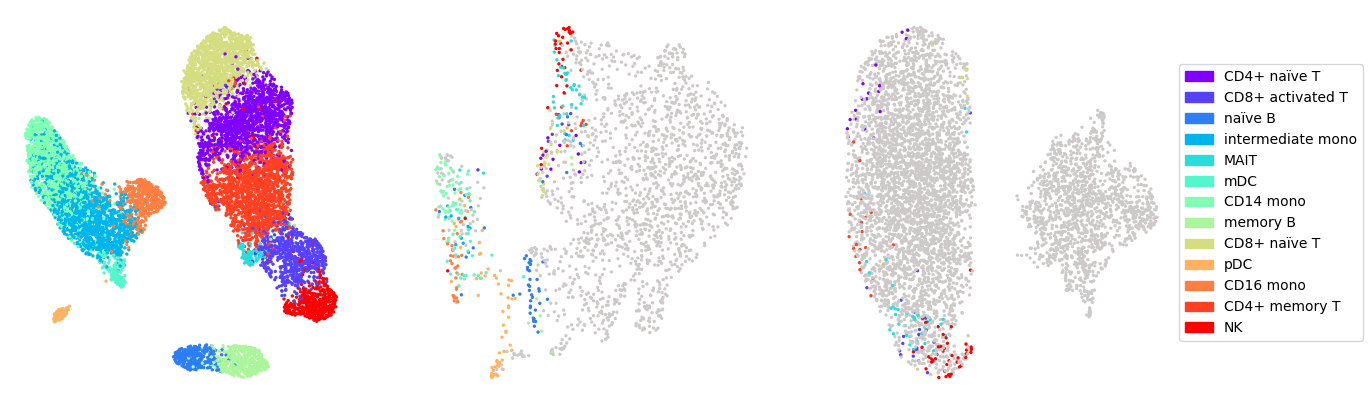

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=32` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


 dim1=16  dim2=16  dim3=16  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.7773448312573192     ARI_cells:0.7241968408631554
Acc_genes:0.8176     ARI_cells:0.09453057749971534


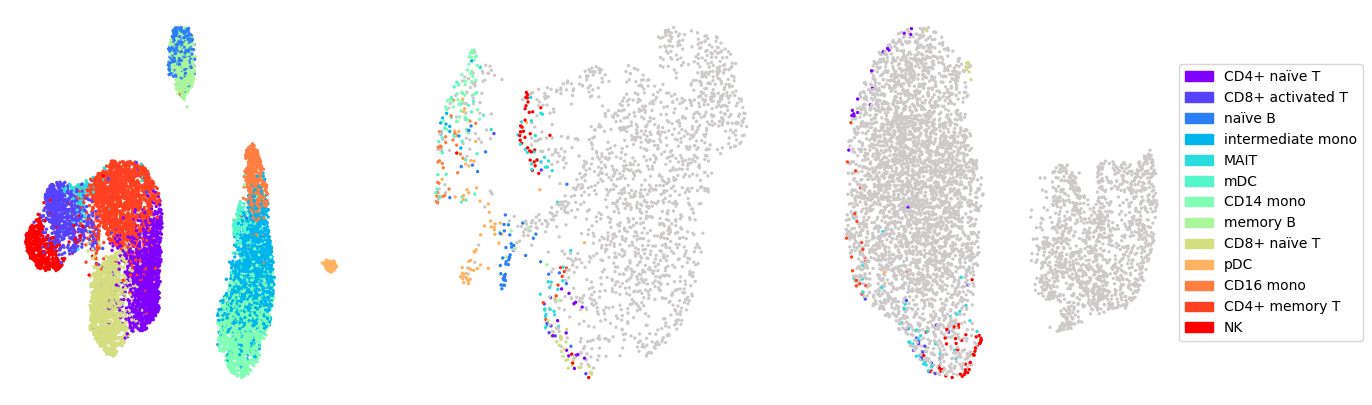

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=32` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


 dim1=16  dim2=16  dim3=16  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.7733631427658894     ARI_cells:0.7365647758119848
Acc_genes:0.83025     ARI_cells:0.26677687616917267


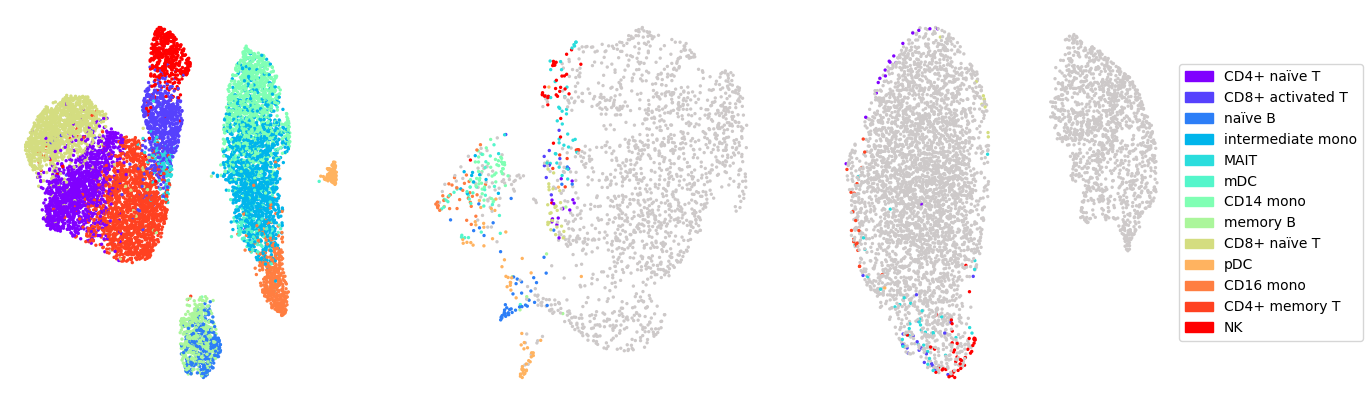

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=64` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


 dim1=32  dim2=32  dim3=32  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.7822633876290854     ARI_cells:0.7287200833549146
Acc_genes:0.8215     ARI_cells:0.22119675108952536


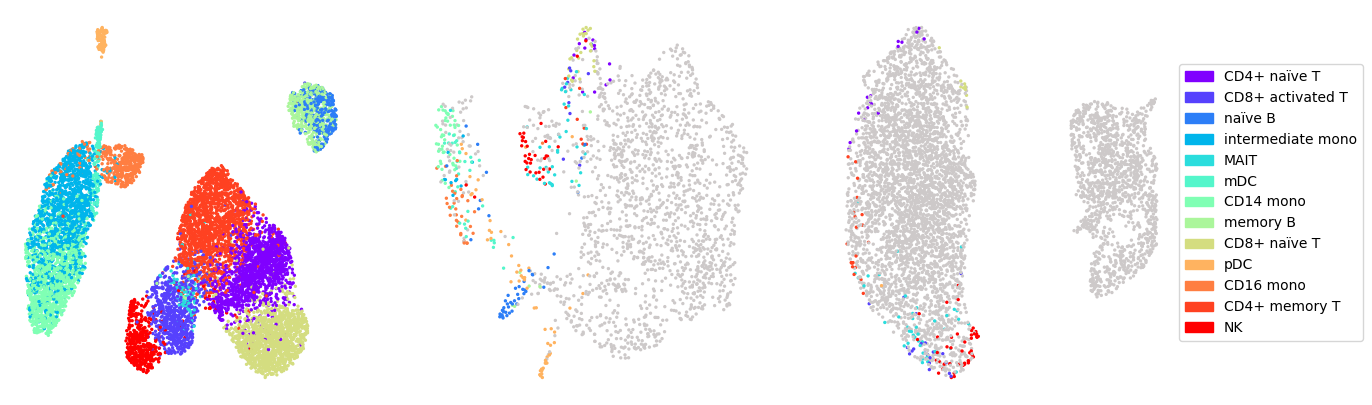

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=64` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


 dim1=32  dim2=32  dim3=32  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.7959544341530927     ARI_cells:0.7219845873549905
Acc_genes:0.8318499999999999     ARI_cells:0.2814783841670033


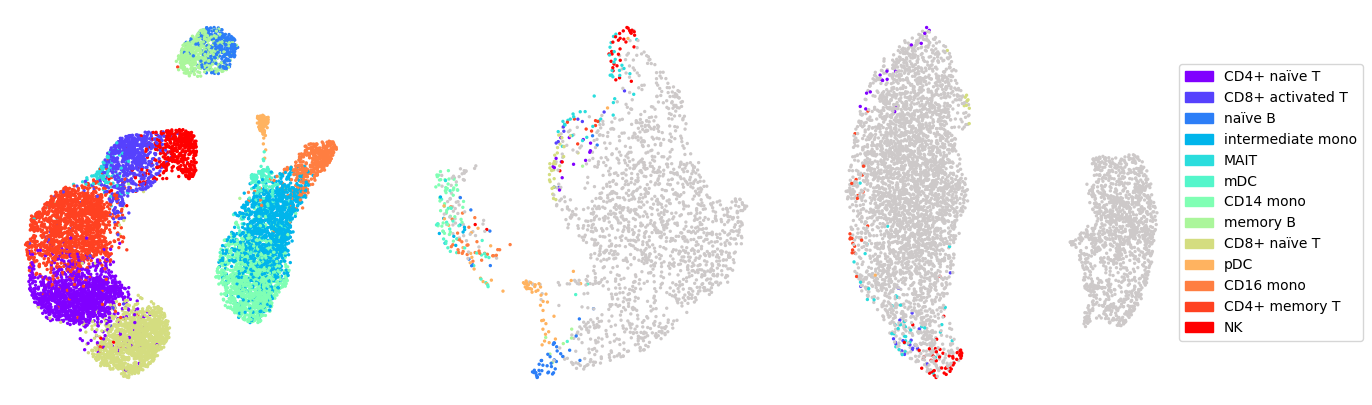

In [12]:
file = open("./Results/global.csv","rb")
dim_arr=[2, 4, 8, 16, 32]
num_epochs_arr=[100, 500]
n_inducing_points_arr=[512]
batch_size_arr=[100000, 60000, 20000, 10000, 10000]
with_PCA_arr=[0]
with_PPCA_arr=[0]
scale_emb1_arr=[0]
scale_emb2_arr=[0]
emb_reg_arr=[0.001]
lr = float(0.01)
kernel = ["RBF"]

for l in range(5):
     for m in range(2):
        for n in range(1): 
            for p in range(1): 
                for q in range(1): 
                    for r in range(1):
                        for s in range(1):
                            for t in range(1):
                                dim1 = dim_arr[l]
                                dim2 = dim_arr[l]
                                dim3 = dim_arr[l]
                                num_epochs = num_epochs_arr[m]
                                n_inducing_points1 = n_inducing_points_arr[n]
                                n_inducing_points2 = n_inducing_points_arr[n]
                                batch_size = batch_size_arr[l]
                                with_PCA=with_PCA_arr[p]
                                with_PPCA=with_PPCA_arr[q]
                                scale_emb1=scale_emb1_arr[r]
                                scale_emb2=scale_emb2_arr[s]
                                emb_reg=emb_reg_arr[t]
                                if (with_PCA==0 or with_PPCA==0):
                                    title = ' dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
                                    save_path = './PBMC10K-MultiView-GPFlux'+title+'/' 
                                    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
                                    hyper_params = {
                                    'I':I,
                                    'J':J,
                                    'K':K,    # the number of entities in each domain
                                    'M1': n_inducing_points1,                  # the number of inducing pairs
                                    'M2': n_inducing_points2,                  # the number of inducing pairs
                                    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
                                    'batch_size':batch_size,      # the size of training batches
                                    'obs_mean1': Y_tr1.mean(),  # the mean of target
                                    'obs_mean2': Y_tr2.mean(),  # the mean of target
                                    'emb_reg': emb_reg,          # l2 norm on the embeddings
                                    'lr': lr,                # the learning rate 
                                    'save_path': save_path,        # path to save the trained models.
                                    }  
                                    
                                    gp_md = GPD(**hyper_params)
                                    gp_md.build(kernels=kernel)
                                    gp_md.load_model((X_tr1+1), (X_tr2+1))
                                    
                                    emb1 = gp_md.emb1
                                    embs1 = emb1((X_tr1+1)[0:-1:J,0])
                                    
                                    emb2 = gp_md.emb2
                                    embs2 = emb2((X_tr1+1)[0:J,1])
                                    
                                    emb3 = gp_md.emb3
                                    embs3 = emb3((X_tr2+1)[0:K,1])
                                    
                                    RNA_struct_MOGP = ad.AnnData(embs1.numpy())
                                    RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()
                                    #sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, n_pcs=8)
                                    sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, use_rep='X')
                                    sc.tl.umap(RNA_struct_MOGP, alpha=0.3, min_dist=.5)
                                    
                                    
                                    Genes_struct_MOGP = ad.AnnData(embs2.numpy())
                                    Genes_struct_MOGP.obsm['X_tsne']= embs2.numpy()
                                    sc.pp.neighbors(Genes_struct_MOGP, n_neighbors=30, n_pcs=8)
                                    sc.tl.umap(Genes_struct_MOGP, alpha=0.3, min_dist=.5)
                                    #sc.pl.umap(Genes_struct_MOGP, use_raw=False, ncols=5, size=70,)
                                    
                                    Peaks_struct_MOGP = ad.AnnData(embs3.numpy())
                                    Peaks_struct_MOGP.obsm['X_tsne']= embs3.numpy()
                                    sc.pp.neighbors(Peaks_struct_MOGP, n_neighbors=30, n_pcs=8)
                                    sc.tl.umap(Peaks_struct_MOGP, alpha=0.3, min_dist=.5)
                                    #sc.pl.umap(Genes_struct_MOGP, use_raw=False, ncols=5, size=70,)
                                    
                                    a1 = pickle.load(file)
                                    a2 = pickle.load(file)
                                    a3 = pickle.load(file)
                                    a4 = pickle.load(file)
                                    a5 = pickle.load(file)
                                    
                                    print(str(a1))
                                    print("Acc_cells:"+str(a2)+"     ARI_cells:"+str(a3))
                                    print("Acc_genes:"+str(a4)+"     ARI_cells:"+str(a5))
                                    Relating_clusters_of_emb1_to_clusters_of_emb2_PBMC10k(rna, atac, RNA_struct_MOGP, Genes_struct_MOGP, Peaks_struct_MOGP, col_dict1=col_dict1, cell_type_list_modified1=cell_type_list_modified1, cell_type_list_modified2=cell_type_list_modified2, n_cell_types=len(list(set(rna.obs["celltype"]))),n_marker_genes=100, use_umap=True, n_marker_peaks=100)
            
file.close()                      

### Multi-view analysis (Local Representation)
#### By adjusting the values of the latent dimensions for both cell and gene embeddings, as well as the number of epochs and batch sizes, we generate embeddings using MOGP. The Accuracy and Rand index for all combinations of selecting two dimensions from the number of dimensionalities are calculated, and the best values for each learned dimensionality are presented.

In [30]:
for filename in glob.glob('./Results/local.csv'):
    os.remove(filename)
os.makedirs("./Results", exist_ok=True)
filehandler = open("./Results/local.csv","wb")
dim_arr=[2, 4, 8, 16]
num_epochs_arr=[100, 500]
n_inducing_points_arr=[512]
batch_size_arr=[100000, 60000, 20000, 10000]
with_PCA_arr=[0]
with_PPCA_arr=[0]
scale_emb1_arr=[0]
scale_emb2_arr=[0]
emb_reg_arr=[0.001]
lr = float(0.01)
kernel = ["RBF"]


for l in range(4):
     for m in range(2):
        for n in range(1): 
            for p in range(1): 
                for q in range(1): 
                    for r in range(1):
                        for s in range(1):
                            for t in range(1):
                                dim1 = dim_arr[l]
                                dim2 = dim_arr[l]
                                dim3 = dim_arr[l]
                                num_epochs = num_epochs_arr[m]
                                n_inducing_points1 = n_inducing_points_arr[n]
                                n_inducing_points2 = n_inducing_points_arr[n]
                                batch_size = batch_size_arr[l]
                                with_PCA=with_PCA_arr[p]
                                with_PPCA=with_PPCA_arr[q]
                                scale_emb1=scale_emb1_arr[r]
                                scale_emb2=scale_emb2_arr[s]
                                emb_reg=emb_reg_arr[t]
                                if (with_PCA==0 or with_PPCA==0):
                                    title = ' dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
                                    save_path = './PBMC10K-MultiView-GPFlux'+title+'/' 
                                    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
                                    hyper_params = {
                                    'I':I,
                                    'J':J,
                                    'K':K,    # the number of entities in each domain
                                    'M1': n_inducing_points1,                  # the number of inducing pairs
                                    'M2': n_inducing_points2,                  # the number of inducing pairs
                                    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
                                    'batch_size':batch_size,      # the size of training batches
                                    'obs_mean1': Y_tr1.mean(),  # the mean of target
                                    'obs_mean2': Y_tr2.mean(),  # the mean of target
                                    'emb_reg': emb_reg,          # l2 norm on the embeddings
                                    'lr': lr,                # the learning rate 
                                    'save_path': save_path,        # path to save the trained models.
                                    }  
                                    
                                    gp_md = GPD(**hyper_params)
                                    gp_md.build(kernels=kernel)
                                    gp_md.load_model((X_tr1+1), (X_tr2+1))
                                    
                                    emb1 = gp_md.emb1
                                    embs1 = emb1((X_tr1+1)[0:-1:J,0])
                                    
                                    emb2 = gp_md.emb2
                                    embs2 = emb2((X_tr1+1)[0:J,1])
                                    
                                    Acc_cells_array=[]
                                    Acc_genes_array=[]
                                    idx_array=[]
                                    for i in range(dim1):
                                        for j in range(i+1,dim1):
                                            idx=[i,j]
                                            
                                            Acc_cells_arr=[]
                                            ARI_cells_arr=[]
                                            for cnt in range (10):
                                                clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
                                                clusterer.fit(embs1.numpy()[:,idx])
                                                cluster_labels = clusterer.predict(embs1.numpy()[:,idx])
                                                labels=np.array([col_dict1[i] for i in rna.obs["celltype"]])
                                                Acc_cells_arr.append(purity_score(labels, cluster_labels)[0]) 
                                                ARI_cells_arr.append(purity_score(labels, cluster_labels)[1]) 
                                            
                                            Acc_genes_arr=[]
                                            ARI_genes_arr=[]
                                            for cnt in range (10):
                                                clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
                                                clusterer.fit(embs2.numpy()[:,idx])
                                                cluster_labels_genes = clusterer.predict(embs2.numpy()[:,idx])
                                                train_labels_genes = np.array([col_dict1[i] for i in C1])
                                                Acc_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[0]) 
                                                ARI_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[1]) 
                                    
                                            Acc_cells_array.append(np.mean(Acc_cells_arr))
                                            Acc_genes_array.append(np.mean(Acc_genes_arr))
                                            idx_array.append(idx)
                                            
                                    pickle.dump(title,filehandler)
                                    pickle.dump(idx_array[np.argmax(Acc_cells_array)],filehandler)
                                    pickle.dump(np.max(Acc_cells_array),filehandler)
                                    pickle.dump(idx_array[np.argmax(Acc_genes_array)],filehandler)
                                    pickle.dump(np.max(Acc_genes_array),filehandler)
filehandler.close()

/tmp/ipykernel_178171/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9198f56ee0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9199004e50>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f919825f040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_178171/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9034488700>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9034488700>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9034488700>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_178171/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9198366f70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179ce5c10>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9198366f70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179ce5dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179ce5c10>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179e33670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9198366f70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f917bf43280>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179ce5c10>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179e33670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f917bf43280>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f917bf43280>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9198366f70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179ce5c10>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179ce5dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9198366f70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179e33670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179e33670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179ce5dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179e33670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


/tmp/ipykernel_178171/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179bbab80>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179bba940>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179bba0d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179bba0d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179bbab80>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179bbab80>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78d30>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78d30>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179de3670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


/tmp/ipykernel_178171/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91799390d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179939dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179939dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179939dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91799390d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179939040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179939dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179939dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179939e50>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179939040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6fdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179939e50>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179cadf70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_178171/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91797878b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91797878b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91797878b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91797878b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91797878b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91797878b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179a78160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f6c7040>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91797878b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179b6f820>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91797878b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f902f990670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f91797878b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9179658af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

In [12]:
file = open("./Results/local.csv","rb")
for l in range(4):
     for m in range(2):
        for n in range(1): 
            for p in range(1): 
                for q in range(1): 
                    for r in range(1):
                        for s in range(1):
                            for t in range(1):
                                a1 = pickle.load(file)
                                a2 = pickle.load(file)
                                a3 = pickle.load(file)
                                a4 = pickle.load(file)
                                a5 = pickle.load(file)
                                print(a1)
                                print(a2)
                                print(a3)
                                print(a4)
                                print(a5)                                    
file.close()

 dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=100  emb_reg=0.001 with_PCA=0
[0, 1]
0.3615032470989034
[0, 1]
0.84435
 dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=500  emb_reg=0.001 with_PCA=0
[0, 1]
0.7621633131055041
[0, 1]
0.85085
 dim1=4  dim2=4  dim3=4  InducingPoints1=512  InducingPoints2=512  BatchSize=60000  epochs=100  emb_reg=0.001 with_PCA=0
[0, 2]
0.6604812094112636
[0, 1]
0.85185
 dim1=4  dim2=4  dim3=4  InducingPoints1=512  InducingPoints2=512  BatchSize=60000  epochs=500  emb_reg=0.001 with_PCA=0
[2, 3]
0.6804748216757159
[1, 2]
0.8534499999999999
 dim1=8  dim2=8  dim3=8  InducingPoints1=512  InducingPoints2=512  BatchSize=20000  epochs=100  emb_reg=0.001 with_PCA=0
[1, 5]
0.6873096987118067
[0, 5]
0.8603
 dim1=8  dim2=8  dim3=8  InducingPoints1=512  InducingPoints2=512  BatchSize=20000  epochs=500  emb_reg=0.001 with_PCA=0
[0, 7]
0.6052060044714149
[0, 4]
0.86065
 dim1=16  dim2=1

#### Among all the settings, the best results are associated with the 2D embedded MOGP embedding, with 500 epochs.

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f982

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f98603ca940>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f98201feb80>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f98201feb80>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

 dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=500  emb_reg=0.001 with_PCA=0
0.7414031725753221 0.7590513406801092
0.8331500000000001 0.4094014271309657


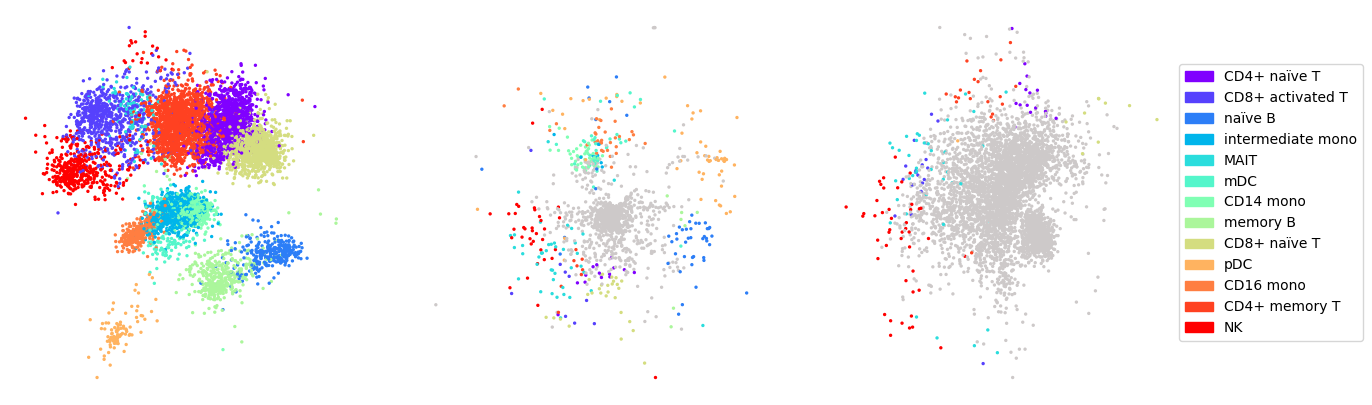

In [13]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 500
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 100000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001
lr = float(0.01)
kernel = ["RBF"]
if (with_PCA==0 or with_PPCA==0):
    title = ' dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
    save_path = './PBMC10K-MultiView-GPFlux'+title+'/' 
    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
    hyper_params = {
    'I':I,
    'J':J,
    'K':K,    # the number of entities in each domain
    'M1': n_inducing_points1,                  # the number of inducing pairs
    'M2': n_inducing_points2,                  # the number of inducing pairs
    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
    'batch_size':batch_size,      # the size of training batches
    'obs_mean1': Y_tr1.mean(),  # the mean of target
    'obs_mean2': Y_tr2.mean(),  # the mean of target
    'emb_reg': emb_reg,          # l2 norm on the embeddings
    'lr': lr,                # the learning rate 
    'save_path': save_path,        # path to save the trained models.
    }  
    
    gp_md = GPD(**hyper_params)
    gp_md.build(kernels=kernel)
    gp_md.load_model((X_tr1+1), (X_tr2+1))
    
    emb1 = gp_md.emb1
    embs1 = emb1((X_tr1+1)[0:-1:J,0])
    
    emb2 = gp_md.emb2
    embs2 = emb2((X_tr1+1)[0:J,1])
    
    emb3 = gp_md.emb3
    embs3 = emb3((X_tr2+1)[0:K,1])
    
    
    RNA_struct_MOGP = ad.AnnData(embs1.numpy())
    RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()
    
    Genes_struct_MOGP = ad.AnnData(embs2.numpy())
    Genes_struct_MOGP.obsm['X_tsne']= embs2.numpy()
    
    Acc_cells_arr=[]
    ARI_cells_arr=[]
    for cnt in range (10):
        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
        clusterer.fit(embs1)
        cluster_labels = clusterer.predict(embs1)
        labels=np.array([col_dict1[i] for i in rna.obs["celltype"]])
        Acc_cells_arr.append(purity_score(labels, cluster_labels)[0]) 
        ARI_cells_arr.append(purity_score(labels, cluster_labels)[1]) 
    
    Acc_genes_arr=[]
    ARI_genes_arr=[]
    for cnt in range (10):
        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
        clusterer.fit(embs2)
        cluster_labels_genes = clusterer.predict(embs2)
        train_labels_genes = np.array([col_dict1[i] for i in C1])
        Acc_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[0]) 
        ARI_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[1]) 
    
    Peaks_struct_MOGP = ad.AnnData(embs3.numpy())
    Peaks_struct_MOGP.obsm['X_tsne']= embs3.numpy()

    print(title)
    print(np.mean(Acc_cells_arr), np.mean(ARI_cells_arr))
    print(np.mean(Acc_genes_arr), np.mean(ARI_genes_arr))   
    
    Relating_clusters_of_emb1_to_clusters_of_emb2_PBMC10k(rna, atac, RNA_struct_MOGP, Genes_struct_MOGP, Peaks_struct_MOGP, col_dict1=col_dict1, cell_type_list_modified1=cell_type_list_modified1, cell_type_list_modified2=cell_type_list_modified2, n_cell_types=len(list(set(rna.obs["celltype"]))),n_marker_genes=100, use_umap=False, n_marker_peaks=100)
            
    